In [ ]:
import os
import random
import sys
from contextlib import contextmanager
from functools import partial

import casadi as ca
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from core.controller import EconomicMPC, GreenHouseModel, GreenhouseSimulator
from core.generator import (
    gen_step,
)
from core.greenhouse_model import GreenHouse, x_init, x_init_dict
from core.openmeteo_query import OpenMeteo
from core.plot import plot_response, plot_states, set_size
from core.simulate import simulate


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


# For reproducibility
random.seed(40)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "CMU Serif",
        "font.serif": "CMU Serif",
    }
)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

In [ ]:
dt = 60

In [ ]:
gh_model = GreenHouse(dt=dt)

In [ ]:
x0 = x_init

u_min = [0.0] * len(gh_model.active_actuators)
u_max = [100.0] * len(gh_model.active_actuators)

y_label = [r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
u_label = [*gh_model.active_actuators.keys()]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

# Get Weather Data

In [ ]:
openmeteo = OpenMeteo(
    latitude=52.52,  # Latitude of the location in degrees
    longitude=13.41,  # Longitude of the location in degrees
    altitude=157,
    tilt=[
        90,
        40,
        90,
        40,
        90,
        40,
        90,
        40,
    ],  # Tilt angle of the surface in degrees
    azimuth=[
        "NE",
        "NE",
        "SE",
        "SE",
        "SW",
        "SW",
        "NW",
        "NW",
    ],  # Azimuth angle of the surface in degrees (South facing)
    frequency="minutely_15",  # Frequency of the data
)

start_date = pd.Timestamp.now()
climdat = openmeteo.get_weather_data(
    start_date=start_date,
    end_date=(start_date + pd.Timedelta(days=15)),
)

climate = climdat.asfreq(f"{dt}s").interpolate(method="time")

In [ ]:
climate.to_csv(
    f"weather-{start_date.strftime("%Y-%m-%d")}_{(start_date + pd.Timedelta(days=15)).strftime("%Y-%m-%d")}.csv"
)

In [ ]:
# Plotting the DataFrame
ax = climdat.plot()

# Placing the legend above the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=3)

# Displaying the plot
plt.show()

In [ ]:
greenhouse_model = partial(gh_model.model, climate=climate.values)

In [ ]:
_greenhouse_model = partial(gh_model._model, climate=climate.values)

## Explore responses to steps in individual inputs

100%|██████████| 21600/21600 [00:21<00:00, 1008.64it/s]


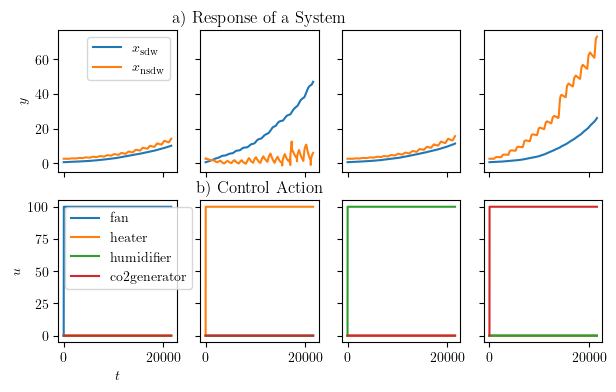

In [ ]:
# [donotremove]
fig, axs = plt.subplots(nrows=2, ncols=len(u_max), sharex=True, sharey="row")

for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=len(climate),
        t_s=dt,
        x0=x0,  # type: ignore
    )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )

axs[0, 0].set_ylabel("$y$")
axs[0, 1].set_title("a) Response of a System")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 1].set_title("b) Control Action")
axs[1, 0].legend()

plt.show()

### Plot all the hidden states

100%|██████████| 21600/21600 [00:21<00:00, 1020.60it/s]


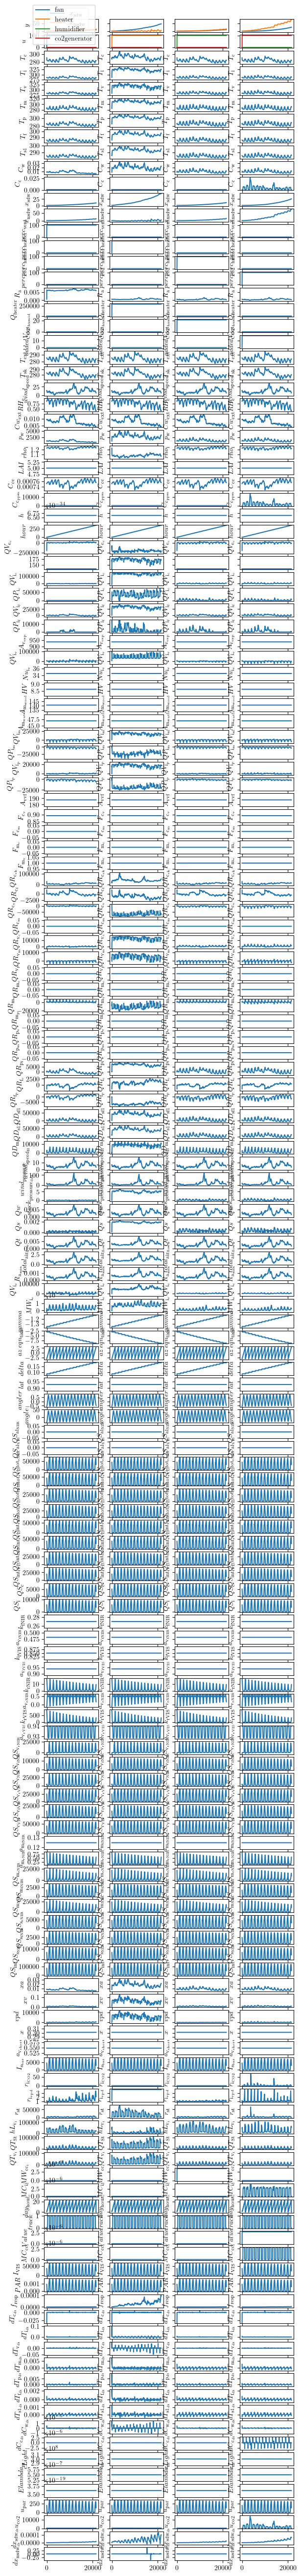

In [ ]:
# [donotremove]
for u_idx in range(len(u_max)):
    u_max_ = u_min.copy()
    u_max_[u_idx] = u_max[u_idx]
    u = partial(gen_step, u_min=u_min, u_max=u_max_)
    t_out, y_out, u_out = simulate(
        greenhouse_model,
        u=u,  # type: ignore
        sim_time=len(climate),
        t_s=dt,
        x0=x0,  # type: ignore
    )

    xs = []
    for i, (x, u) in enumerate(zip(y_out, u_out)):
        _, x_ = _greenhouse_model(i * dt, tuple(x), tuple(u))
        xs.append(x_)
    df = pd.DataFrame(xs, index=t_out).select_dtypes(include=["float"])

    if u_idx == 0:
        # Plot response
        fig, axs = plt.subplots(
            nrows=2 + len(df.columns),
            ncols=len(u_max),
            figsize=(6, round(len(df.columns) / 2)),
            sharex=True,
            sharey="row",
        )
    plot_response(
        t_out,
        y_out[:, -2:],
        u_out,
        axs_=axs[:, u_idx],
        y_label=y_label,
        u_label=u_label,
    )
    # Plot states
    plot_states(df, axs[2:, u_idx])

axs[0, 0].set_ylabel("$y$")
axs[0, 0].legend()
axs[1, 0].set_xlabel("$t$")
axs[1, 0].set_ylabel("$u$")
axs[1, 0].legend()

plt.show()

In [ ]:
# === Model ===================================================================
# Create a model instance
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

# === Simulator ===============================================================
# Create a simulator
simulator = GreenhouseSimulator(model, climate)

# === Runtime =================================================================
sim_steps = len(climate)
# Find feasible initial state
x0 = x_init
u0 = np.array([50.0] * len(gh_model.active_actuators), ndmin=2).T

simulator.x0 = x0

# Run the MPC simulation
u0s = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
x0s = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
ums = []
for step in tqdm(range(sim_steps)):
    with suppress_stdout():
        u0s.iloc[step] = u0.flatten()
        ums.append([u_min, u_max])
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            print("x0 contains NaN values.")
            break
        x0s.iloc[step] = x0.flatten()

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

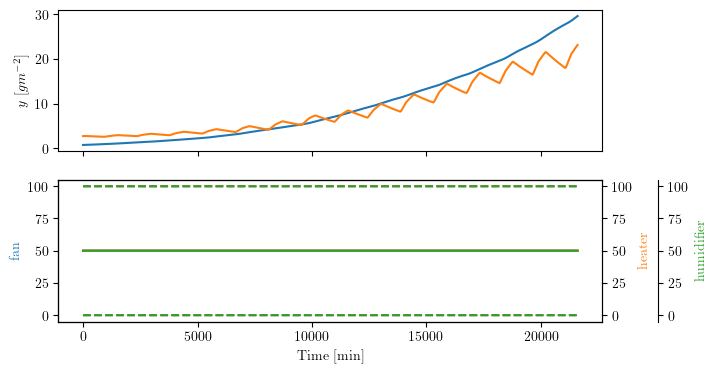

In [ ]:
# [donotremove]
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(timestamps, x0s.iloc[:, -2:])
axs[0].set_ylabel("$y~[g m^{-2}]$")
for i, (um, label, color) in enumerate(zip(np.array(ums).T, u_label, colors)):
    # Create a second y-axis
    if i > 0:
        ax = axs[1].twinx()
    else:
        ax = axs[1]
    if i > 1:
        ax.spines["right"].set_position(("outward", 20 * i))
    ax.plot(timestamps, np.array(u0s).squeeze()[:, i], color=color)
    ax.plot(
        timestamps,
        um[0, :],
        linestyle="--",
        color=color,
    )
    ax.plot(
        timestamps,
        um[1, :],
        linestyle="--",
        color=color,
    )

    ax.set_ylabel(label, color=color)
    ax.set_xlabel("Time [min]")

In [ ]:
model = GreenHouseModel(gh_model, climate_vars=climate.columns)

lettuce_price = 0.0054  # EUR/g
N = 60  # number of control intervals
u_min = 0.0
u_max = 100.0

mpc = EconomicMPC(
    model,
    climate,
    lettuce_price,
    N,
    u_min=u_min,
    u_max=u_max,
)

simulator = GreenhouseSimulator(model, climate)


# === Runtime =================================================================
sim_steps = 60  # int(len(climate)/dt - N - 1)  # [1/dt]
# Find feasible initial state
x0 = x_init
u0 = np.array([50.0] * len(gh_model.active_actuators))
for k in range(N):
    k1 = greenhouse_model(k, x0, u0)
    k2 = greenhouse_model(k, x0 + dt / 2 * k1, u0)
    k3 = greenhouse_model(k, x0 + dt / 2 * k2, u0)
    k4 = greenhouse_model(k, x0 + dt * k3, u0)
    x_next = x0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    x0 = x_next

mpc.x0 = x0
mpc.u0 = np.array([50.0] * model.n_u)
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

# Run the MPC simulation
u0s = pd.DataFrame(
    columns=[
        act for act, active in gh_model.active_actuators.items() if active == 1
    ],
    index=range(sim_steps),
)
x0s = pd.DataFrame(columns=[*x_init_dict.keys()], index=range(sim_steps))
for step in tqdm(range(sim_steps)):
    if step * dt + N + 1 > len(climate):
        if step + N == len(climate):
            print("Fetching new forecast")
            start_date = start_date + pd.Timedelta(seconds=step * dt)
            climate = (
                openmeteo.get_weather_data(
                    start_date=start_date,
                    end_date=(start_date + pd.Timedelta(days=1)).strftime(
                        "%Y-%m-%d"
                    ),
                )
                .asfreq(f"{dt}s")
                .interpolate(method="time")
            )

            mpc.climate = climate
            simulator.climate = climate
            print("Simulating ...")

    with suppress_stdout():
        u0 = mpc.make_step(x0)
        u0s.iloc[step] = u0.flatten()
        x0 = simulator.make_step(u0)
        if np.isnan(x0).any():
            print("x0 contains NaN values.")
            break
        x0s.iloc[step] = x0.flatten()

timestamps = pd.date_range(
    start=start_date, periods=sim_steps, freq=pd.Timedelta(seconds=dt)
)

In [ ]:
profit = pd.Series(
    mpc.lettuce_price
    * (x0[-2:].sum() - x_init[-2:].sum())
    / 0.1
    * mpc.cultivated_area,
    index=["Lettuce profit "],
)

costs = pd.Series(
    index=[f"Energy ({i})" for i in u0s.columns]
    + [f"CO2 ({i})" for i in u0s.columns]
)
for act in [
    act for act, active in model.gh.active_actuators.items() if active
]:
    actuator = getattr(model.gh, act)
    costs[f"Energy ({act})"] = -actuator.signal_to_eur(u0s[act]).sum()
    costs[f"CO2 ({act})"] = -actuator.signal_to_co2_eur(u0s[act]).sum()

profit_costs = pd.concat([profit, costs])

In [ ]:
print(
    f"Congrats, your greenhouse generated profit of {profit_costs.sum():.2f} EUR! 🤑"
)

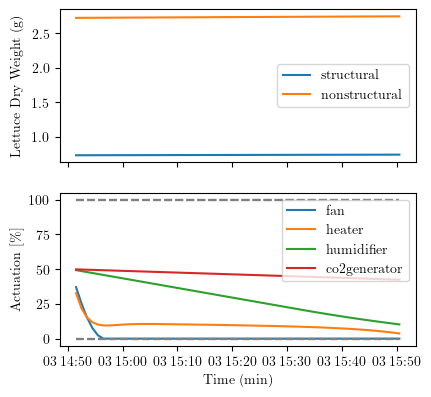

In [ ]:
# [donotremove]
fig, axs = plt.subplots(
    2, 1, sharex=True, figsize=set_size(width="ieee", subplots=(2, 1))
)
axs[0].plot(
    timestamps,
    x0s.iloc[:, -2],
    label="structural",
)
axs[0].plot(
    timestamps,
    x0s.iloc[:, -1],
    label="nonstructural",
)
axs[0].set_ylabel("Lettuce Dry Weight (g)")
axs[0].legend()
for i, (label, color) in enumerate(
    zip(
        gh_model.active_actuators.keys(),
        colors,
    )
):
    ax: plt.Axes = axs[1]
    ax.plot(
        timestamps,
        np.array(u0s).squeeze()[:, i],
        color=color,
        label=label,
    )
    ax.set_ylabel("Actuation [\\%]")
    ax.set_xlabel("Time (min)")
    ax.legend()

ax.hlines(
    [u_min, u_max],
    xmin=timestamps[0],
    xmax=timestamps[-1],
    linestyle="--",
    color="gray",
)


fig.align_ylabels()

fig.savefig("greenhouse_control.pdf")

In [ ]:
import numpy as np

# === Model ===================================================================
# Time step and horizon parameters
dt = 60 * 2  # [s]
N = 60  # number of control intervals

# Define system dimensions
n_states = len(x_init)
n_controls = 2


# Define CasADi variables for state, control, and parameters
x = ca.MX.sym("x", n_states)
u = ca.MX.sym("u", n_controls)
t = ca.MX.sym("t")
tvp = {name: ca.MX.sym(name) for name in climate.columns}


# Define the system dynamics function
def f(t, x, u, tvp):
    return ca.vertcat(
        *gh_model.model(
            t, ca.vertsplit(x), ca.vertsplit(u), climate=tuple(tvp.values())
        )
    )


# RK4 integration to find x_next
k1 = f(t, x, u, tvp)
k2 = f(t, x + dt / 2 * k1, u, tvp)
k3 = f(t, x + dt / 2 * k2, u, tvp)
k4 = f(t, x + dt * k3, u, tvp)
x_next = (x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)).T

# === MPC =====================================================================
# Define optimization variables
U = ca.MX.sym("U", N, n_controls)
X = ca.MX.sym("X", N + 1, n_states)

# Define the cost function
lettuce_price = 0.0054  # EUR/g

# Initial cost
cost = 0

# Calculate the cost over the horizon
for k in range(N):
    # System dynamics
    t_k = t + k * dt
    # tvp_k = {key: climate[key][start_date + pd.Timedelta(seconds=t_k)] for key in climate.columns}
    cost += (
        -(lettuce_price**2) * gh_model.A_c**2 * X[k, -2] ** 2
        + gh_model.fan.signal_to_eur(U[k, 0]) ** 2
        + gh_model.fan.signal_to_co2_eur(U[k, 0]) ** 2
        + gh_model.heater.signal_to_eur(U[k, 1]) ** 2
        + gh_model.heater.signal_to_co2_eur(U[k, 1]) ** 2
    )
    # Add dynamics constraint
    x_next_k = ca.MX(x_next)
    x_k = ca.vertcat(X[k + 1, :])
    cost += ca.dot(x_next_k - x_k, x_next_k - x_k)

# === IPOPT solver setup =====================================================

# Define constraints (box constraints on controls)
u_min = np.array([0.0, 0.0])
u_max = np.array([100.0, 100.0])
lb_u = np.tile(u_min, N)
ub_u = np.tile(u_max, N)

# Define the optimization problem
nlp = {
    "x": ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1)),
    "f": cost,
    "g": ca.vertcat(
        *[X[k + 1, :] - x_next for k in range(N)]
    ),  # dynamics constraints
}

# Create IPOPT solver
opts = {
    "ipopt.print_level": 0,
    "ipopt.max_iter": 500,
    "ipopt.tol": 1e-8,
    "ipopt.linear_solver": "MA57",
    "ipopt.allow_free": True,
}
solver = ca.nlpsol("solver", "ipopt", nlp, opts)

# === Runtime Simulation ======================================================
x0 = x_init
u0 = np.array([0.0, 0.0])

# Prepare storage for results
x0s = []
u0s = []
y_nexts = []

for step in range(sim_steps):
    if step * dt + N + 1 > len(climate):
        if climate.index[-1] < pd.Timestamp.now():
            print("Fetching new forecast")
            start_date = start_date + pd.Timedelta(seconds=step * dt)
            climdat = openmeteo.get_weather_data(
                start_date=start_date.strftime("%Y-%m-%d"),
                end_date=(start_date + pd.Timedelta(days=8)).strftime(
                    "%Y-%m-%d"
                ),
            )
            climate = climdat.asfreq("1s").interpolate(method="time")
        else:
            break

    # Solve the optimization problem
    sol = solver(
        x0=ca.vertcat(
            ca.reshape(ca.DM(x0), -1, 1), ca.reshape(ca.DM(u0), -1, 1)
        ),
        lbg=0,
        ubg=0,
        lbx=np.concatenate([x0.ravel()] * (N + 1) + [lb_u.ravel()] * N),
        ubx=np.concatenate([x0.ravel()] * (N + 1) + [ub_u.ravel()] * N),
    )
    u_opt = np.array(sol["x"][N * n_states :].full()).reshape(N, n_controls)
    x_next = np.array(sol["x"][: (N + 1) * n_states].full()).reshape(
        N + 1, n_states
    )

    # Apply the first control input
    u0 = u_opt[0, :]
    u0s.append(u0)
    y_next = x_next[1, :]
    y_nexts.append(y_next[-2:])
    x0 = y_next
    x0s.append(x0)

    # Check for NaN values in the states
    if np.isnan(x0).any():
        raise ValueError("x0 contains NaN values.")